In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fixed_point
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import estimation_functions
# from integrated_market_model.market import IntegratedMarketModel

In [56]:
np.random.seed(100)

In [57]:
df = pd.read_csv(f'../data/market_integrates_1.csv')
print(df)


     market_ids  firm_ids  characteristic1  characteristic2    prices  \
0             1         1         5.533338        20.855216  5.974816   
1             1         2         5.376039        20.650171  6.912039   
2             1         3         5.713958        20.379129  7.081274   
3             1         4         5.033581        20.989227  6.575680   
4             1         5         5.591846        20.380606  6.545344   
..          ...       ...              ...              ...       ...   
995         100         6         5.830374        20.702445  5.830901   
996         100         7         5.946392        20.314758  5.636238   
997         100         8         5.543462        20.189176  5.696452   
998         100         9         5.201490        20.021045  7.016530   
999         100        10         5.888071        20.440777  6.199270   

     marginal_cost    shares   profits   markups  e_quantity    capital  \
0         2.576321  0.017780  0.060424  2.319128

In [58]:
n_firms = 10

df2 = df.groupby('market_ids').sum('shares')
outside_good = np.repeat(np.array(df2.shares), n_firms)

# Get outside good same shape datagrame repeat each 10 times 
y = np.log(np.array(df.shares)) - np.log(outside_good)
print(y)


[-2.2386701  -2.36013656 -2.49232101 -2.19976851 -2.28796114 -2.59397758
 -2.27583822 -2.08257129 -2.15596221 -2.45179696 -2.18285982 -2.34507148
 -2.47868265 -2.26548045 -2.29656759 -2.54129557 -2.31399151 -2.07967794
 -2.16419573 -2.45619387 -2.24950913 -2.31976139 -2.39685159 -2.24459621
 -2.33821843 -2.55262108 -2.36370278 -2.06825951 -2.15986753 -2.41817873
 -2.34780163 -2.40058379 -2.45541619 -2.19031424 -2.25501018 -2.48735133
 -2.30796951 -2.06654369 -2.17223533 -2.43000721 -2.30299998 -2.35539094
 -2.4473285  -2.18522743 -2.20982336 -2.5416171  -2.31969343 -2.17333686
 -2.15030609 -2.41687423 -2.25302122 -2.35885683 -2.44928105 -2.17497356
 -2.20329379 -2.52355737 -2.23488724 -2.27162202 -2.17282376 -2.4556615
 -2.24150332 -2.35527224 -2.50802655 -2.25170341 -2.17442216 -2.49685945
 -2.26337627 -2.25087201 -2.16118442 -2.38952322 -2.24808115 -2.32652715
 -2.51624118 -2.21971796 -2.16192373 -2.4706553  -2.23104481 -2.24919367
 -2.28133934 -2.37859035 -2.34423225 -2.38390628 -2.

In [59]:
# Easy ols estimation 

x = df[['prices', 'characteristic1', 'characteristic2']]

res = LinearRegression().fit(x, y)

print('Intercept: \n', res.intercept_)
print('Coefficients: \n', res.coef_)



Intercept: 
 5.622553202633121
Coefficients: 
 [-0.17808614 -0.40559872 -0.2219042 ]


In [60]:
# Frist stage regression some work 

x = df[['marginal_cost', 'characteristic1', 'characteristic2']]

res = LinearRegression().fit(x, df['prices'])

print('Intercept: \n', res.intercept_)
print('Coefficients: \n', res.coef_)

predictions_price = res.predict(x)
df['predict_prices'] = predictions_price


Intercept: 
 2.0872638194186397
Coefficients: 
 [ 1.52861552 -0.01681445 -0.01026424]


In [61]:
# Second stage: 

x = df[['predict_prices', 'characteristic1', 'characteristic2']]

res = LinearRegression().fit(x, y)

print('Intercept: \n', res.intercept_)
print('Coefficients: \n', res.coef_)



Intercept: 
 7.786346286928505
Coefficients: 
 [-0.26412329 -0.47527247 -0.28190394]


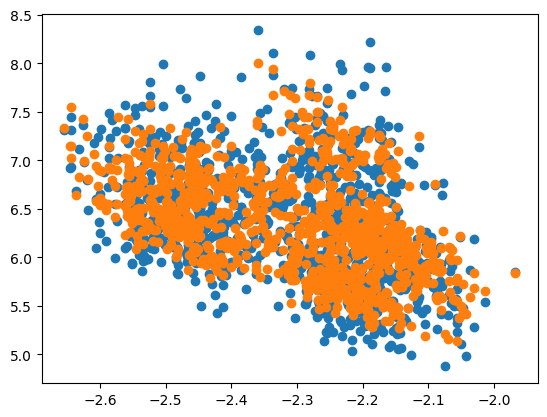

In [62]:

plt.scatter(y, df.prices)
plt.scatter(y, df.predict_prices)
plt.show()

In [63]:
# theta_0 = np.array([2, -0.5, 0.3, 0.05, 1.])
# theta_0 = np.array([2., -0.5, -0.3, 0.5, 1.])

# theta_0 = np.array([1.5, -1, -0.5, 0.5, 1.])
# theta_0 = np.array([1., 1., 1., 1., 1.])





In [71]:
def f(theta, df, n_consumers, n_firms, T):
    # true_shares = np.array(df.shares)
    true_share = np.log(np.array(df.shares))
    all_est_shares = np.zeros(T*n_firms)
    v_p_all = np.random.normal(0, 1, n_consumers*T)
    for t in range(0, T-1):
        v_p = v_p_all[t*n_consumers:(t+1)*n_consumers]
        estimates_shares_market = np.log(estimation_functions.simulate_market_shares_per_period(theta, df, v_p, n_consumers, n_firms, t))
        all_est_shares[t*n_firms:(t+1)*n_firms] = estimates_shares_market
    
    mse = mean_squared_error(true_share, all_est_shares)
    return mse

In [65]:
def minimization_objective_function(theta, df, n_consumers, n_firms, time):

    # v_p_all = np.random.normal(0, 1, n_consumers*time)
    v_p_all = np.zeros(n_consumers*time)
    all_est_shares = np.zeros(time*n_firms)

    for t in range(0, time):
        v_p = v_p_all[t*n_consumers:(t+1)*n_consumers]
        try1 = estimation_functions.simulate_market_shares_per_period(theta, df, v_p, n_consumers, n_firms, t)
        all_est_shares[t*n_firms:(t+1)*n_firms] = try1
    
    # T = indirect_utility_all + np.log(df.shares/all_est_shares)
    return mean_squared_error(df.shares, all_est_shares)
    # return np.sum(df.shares - all_est_shares)
    # return T

In [66]:
def solve_delta(theta, df, n_consumers, n_firms, time):

    # v_p_all = np.random.normal(0, 1, n_consumers*time)
    v_p_all = np.zeros(n_consumers*time)
    all_est_shares = np.zeros(time*n_firms)
    all_indirect_utilities = np.zeros(time*n_firms)

    for t in range(0, time):
        v_p = v_p_all[t*n_consumers:(t+1)*n_consumers]
        try1 = estimation_functions.simulate_market_shares_per_period(theta, df, v_p, n_consumers, n_firms, t)
        try2 = estimation_functions.get_indirect_utility(theta, df, n_firms, t)
        all_est_shares[t*n_firms:(t+1)*n_firms] = try1
        all_indirect_utilities[t*n_firms:(t+1)*n_firms] = try2

    
    return all_indirect_utilities + np.log(df.shares/all_est_shares)


[ 6.11286337e-01 -3.95139800e+00 -4.64297971e+00 -2.44734483e+00
 -2.36174571e+00 -3.29294118e+00  5.93807591e-01 -6.38383272e-01
 -5.98490107e+00 -1.96754506e+00 -7.96756989e-01 -6.71607668e+00
 -7.56629594e+00 -6.52102751e+00 -5.30541015e+00 -5.29934972e+00
 -2.43671951e+00 -3.05124493e+00 -9.44024597e+00 -4.82473770e+00
  8.05124003e-01 -2.62106627e+00 -2.39533329e+00 -2.53933461e+00
 -2.54571801e+00 -1.96412000e+00 -3.15042316e-01 -4.09866065e-02
 -5.20855517e+00 -9.11834309e-01 -1.27873943e+00 -4.77144609e+00
 -4.15379932e+00 -2.46601877e+00 -2.01284197e+00 -1.71288865e+00
 -1.17737215e-01 -6.11894403e-01 -6.38915608e+00 -1.79541945e+00
  1.07443406e+00 -2.09340953e+00 -2.09125960e+00 -6.06155602e-01
  3.76585523e-01 -7.41627486e-01  1.33473945e+00 -5.08150606e-01
 -3.97985947e+00  1.49196964e-01 -3.78150795e-01 -4.69133360e+00
 -4.67105495e+00 -2.81452195e+00 -1.77928805e+00 -2.89175020e+00
  4.43640579e-01 -4.44040193e+00 -7.02824484e+00 -2.79899777e+00
  2.91031166e-02 -4.49405

indirect_utility_at_true_param = estimation_function.ge()

In [68]:
n_consumers = 1000
firms  = 10
time = 100 
theta_0 = np.array([1., 1., 1., 1., 1.])
# theta_0 = np.ones(5)
res = minimize(
        minimization_objective_function, 
        theta_0, 
        args=(df, n_consumers, firms, time)
      )
optim_vec = res.x
print(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0068775074384871656
        x: [ 1.000e+00 -5.161e-02 -3.604e-02 -1.080e+01  1.000e+00]
      nit: 26
      jac: [ 1.701e-06  1.911e-06  4.088e-06 -4.598e-09  0.000e+00]
 hess_inv: [[ 1.000e+00 -2.728e-02 ... -2.065e-01 -1.285e-09]
            [-2.728e-02  5.708e+02 ...  5.240e+03  5.169e-05]
            ...
            [-2.065e-01  5.240e+03 ...  5.044e+04  5.362e-04]
            [-1.285e-09  5.169e-05 ...  5.362e-04  1.000e+00]]
     nfev: 168
     njev: 28


In [69]:
# Get the function for the fixed point iteration 

In [70]:
N = 500
firms  = 5
time = 100 

all_val_b0 = []
all_val_b1 = []
all_val_b2 = []
all_val_mu = []
all_val_omega = []
mean_share = []

for l in range(1, 5):
    
    res = minimize(f, theta_0, args=(df, N, firms, time), method = 'Nelder-Mead')
    optim_vec = res.x

    all_val_b0.append(optim_vec[0])
    all_val_b1.append(optim_vec[1])
    all_val_b2.append(optim_vec[2])
    all_val_mu.append(optim_vec[3])
    all_val_omega.append(optim_vec[4])

    # new_shares = estimation_functions.shares_optimal(optim_vec, df, v_p, N, firms, time)


df_estimation_values = pd.DataFrame({'beta_0': all_val_b0,
                                    'beta_1': all_val_b1,
                                    'beta_2': all_val_b2, 
                                    'mu': all_val_mu, 
                                    'omega': all_val_omega, 
                                    })
df_estimation_values.to_csv(f'../data/first_estimation_market_inter_100', index=False)


ValueError: Found input variables with inconsistent numbers of samples: [1000, 500]

In [ ]:
print(df_estimation_values)
df_estimation_values.to_csv(f'../data/estimation_thetaones.csv', index=False)

     beta_0    beta_1    beta_2        mu     omega
0  1.251203 -1.048799 -0.059659  1.018718  1.505539
1  0.933265 -1.121926 -0.050857  1.038126  1.634821
2  1.285060 -1.031074 -0.084013  1.099431  1.603690
3  1.288822 -1.105628 -0.066474  1.037821  1.606252


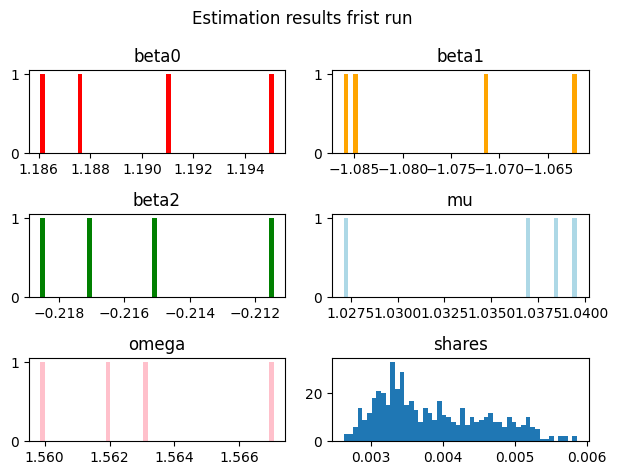

In [ ]:
fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2)
fig.suptitle(f'Estimation results frist run')

ax1.hist(df_estimation_values.beta_0, bins=50, color='red')
ax2.hist(df_estimation_values.beta_1, bins=50, color='orange')
ax3.hist(df_estimation_values.beta_2, bins=50, color='green')
ax4.hist(df_estimation_values.mu, bins=50, color='lightblue')
ax5.hist(df_estimation_values.omega, bins=50, color='pink')
ax6.hist(df.shares, bins=50)


ax1.set_title('beta0')
ax2.set_title('beta1')
ax3.set_title('beta2')
ax4.set_title('mu')
ax5.set_title('omega')
ax6.set_title('shares')

plt.tight_layout()
plt.show()
